<a href="https://colab.research.google.com/github/Kevan123/MRV-Blue-Carbon-Project-LAC-2025/blob/proofofconcept/MRV_AGC_Data_Sim_%26_ML_Model_(Proof_of_Concept).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proof of Concept / Mock Up

This is a mock up of the data modelling and machine learning process.
The variables simulated here are based on real-world ABG CS computation and the modelling process as well.
The data is simulated.

*Please note the final results may be different based on the data received in the MRV Blue Carbon Consultancy. This workbook is intended only for conceptual purposes.*

# Goal - Simulate Data

## Understanding The Data
(simulation)
1. Location & metadata: Country, Region, CRS, Latitude, Longitude, plus placeholder Projected_X/Y.

2. Spectral features: NDVI, EVI, LAI_Proxy.

3. Texture/structural: GLCM_Entropy, PCA1.

4. Environment: DEM_Elev_m, Slope_deg, Soil_pH, Soil_BulkDensity_gcc, Distance_to_Coast_m, Salinity_Proxy.

5. Target: AGB_Carbon_tonnes.

6. Provenance: Imagery_Date (2015-07-29), Label_Source (LiDAR 2014 aligned to 2015), Validation_Source (Plots/TLS 2025).

***Specifically:***
- Pixel_ID - Unique identifier for each 10×10 m grid cell (e.g., CAR_00001).
- Country - "Trinidad and Tobago", the study area.
- Region - "Caroni Swamp", the specific mangrove area.
- CRS - Coordinate Reference System (EPSG:4326 = WGS84 lat/lon).
- Latitude / Longitude - Geographic coordinates (degrees).
- Projected_X / Projected_Y - Pseudo-meter coordinates derived from lat/lon, useful for spatial indexing in ML pipelines.
- Imagery_Date - "2015-07-29", Sentinel-2 acquisition date aligned with LiDAR baseline.
- NDVI (Normalized Difference Vegetation Index) → Proxy for vegetation “greenness” and health (higher NDVI = denser, healthier canopy).
- EVI (Enhanced Vegetation Index) → Similar to NDVI but more sensitive in high biomass regions like mangroves.
- LAI_Proxy (Leaf Area Index Proxy) → Derived non-linear transform of NDVI, representing leaf density/canopy cover.
- GLCM_Entropy - Texture metric from Grey-Level Co-occurrence Matrix (higher = more canopy complexity).
- PCA1 - First principal component from multispectral data, capturing major variance across bands.
- DEM_Elev_m - Elevation from a Digital Elevation Model (meters). Caroni is low-lying (0–5 m).
- Slope_deg - Derived slope (degrees), typically low in mangrove swamps.
- Soil_pH - Soil acidity/alkalinity; influences root systems and biomass
- Soil_BulkDensity_gcc - Soil compaction/density (g/cm³), important for root biomass and soil carbon storage.
- Distance_to_Coast_m - Proxy for tidal influence and salinity, distance from shoreline (meters).
- Salinity_Proxy - Synthetic variable (inverse of distance to coast), higher values near the shoreline.

- AGB_Carbon_tonnes - Above-Ground Biomass Carbon Stock (tonnes per 10×10 m pixel).

In [3]:
import numpy as np
import pandas as pd

np.random.seed(7)

n = 1000

# Geographic bounds for Caroni Swamp, Trinidad (approx)
lat = np.random.uniform(10.55, 10.70, n)
lon = np.random.uniform(-61.50, -61.33, n)

# Create a simple projected X/Y placeholder (not true projection; for mock structure)
# We'll scale lon/lat into pseudo-meters around a local origin for illustration.
x_coord = (lon + 61.50) * 100000  # ~meter-like scale
y_coord = (lat - 10.55) * 100000

# Spectral features
ndvi = np.clip(np.random.beta(5, 2, n)*0.9 + 0.1, 0.3, 0.95)  # skew high for healthy mangrove #can get from Hamish
evi = np.clip(0.6*ndvi + np.random.normal(0, 0.05, n), 0.2, 0.85) #can get from Hamish

# LAI proxy via NDVI-based non-linear transform (capped)
lai_proxy = 3.618 * (ndvi / np.clip((1 - ndvi), 1e-3, None))
lai_proxy = np.clip(lai_proxy, 0, 7)

# Texture (higher canopy complexity -> moderate entropy; inversely related to NDVI)
glcm_entropy = np.clip(6 - 3*ndvi + np.random.normal(0, 0.3, n), 2.0, 6.5)

# PCA first component (synthetic)
pca1 = np.random.normal(0, 1, n)

# Environmental covariates
dem_elev = np.clip(np.random.gamma(shape=2.0, scale=0.8, size=n), 0, 6)  # low-lying
slope_deg = np.clip(np.random.gamma(shape=1.5, scale=1.5, size=n), 0, 15)
soil_ph = np.clip(np.random.normal(6.2, 0.4, n), 5.2, 7.8)
soil_bd = np.clip(np.random.normal(1.30, 0.15, n), 0.9, 1.8)  # g/cm^3

# Distance to coast (proxy) and salinity (inverse of distance, synthetic)
dist_coast_m = np.random.uniform(50, 3000, n)
salinity_proxy = np.clip(1.0 / (dist_coast_m/500.0), 0.1, 10)  # higher near coast

# Target: AGB Carbon Stock per 10x10m pixel (tonnes) - synthetic generative model
# Increase with NDVI & LAI, modest with soil BD, decrease with elevation/slope; noise added
base = 30 + 90*ndvi + 4*lai_proxy + 8*(soil_bd - 1.2) - 2*dem_elev - 0.5*slope_deg
noise = np.random.normal(0, 8, n)
agb_carbon = np.clip(base + noise, 10, 180)

df = pd.DataFrame({
    "Pixel_ID": [f"CAR_{i:05d}" for i in range(n)],
    "Country": "Trinidad and Tobago",
    "Region": "Caroni Swamp",
    "CRS": "EPSG:4326",
    "Latitude": np.round(lat, 6),
    "Longitude": np.round(lon, 6),
    "Projected_X": np.round(x_coord, 2),
    "Projected_Y": np.round(y_coord, 2),
    "Imagery_Date": "2015-07-29",
    "NDVI": np.round(ndvi, 3),
    "EVI": np.round(evi, 3),
    "LAI_Proxy": np.round(lai_proxy, 3),
    "GLCM_Entropy": np.round(glcm_entropy, 3),
    "PCA1": np.round(pca1, 3),
    "DEM_Elev_m": np.round(dem_elev, 2),
    "Slope_deg": np.round(slope_deg, 2),
    "Soil_pH": np.round(soil_ph, 2),
    "Soil_BulkDensity_gcc": np.round(soil_bd, 2),
    "Distance_to_Coast_m": np.round(dist_coast_m, 1),
    "Salinity_Proxy": np.round(salinity_proxy, 3),
    "AGB_Carbon_tonnes": np.round(agb_carbon, 2),
})



In [4]:
df.head()

,Pixel_ID,Country,Region,CRS,Latitude,Longitude,Projected_X,Projected_Y,Imagery_Date,NDVI,...,LAI_Proxy,GLCM_Entropy,PCA1,DEM_Elev_m,Slope_deg,Soil_pH,Soil_BulkDensity_gcc,Distance_to_Coast_m,Salinity_Proxy,AGB_Carbon_tonnes
0,CAR_00000,Trinidad and Tobago,Caroni Swamp,EPSG:4326,10.561446,-61.485756,1424.36,1144.62,2015-07-29,0.791,...,7.000,3.613,0.961,0.78,3.92,6.17,1.10,2139.3,0.234,122.55
1,CAR_00001,Trinidad and Tobago,Caroni Swamp,EPSG:4326,10.666988,-61.410554,8944.60,11698.78,2015-07-29,0.308,...,1.612,4.716,0.943,1.05,2.46,6.57,1.32,2089.4,0.239,64.65
2,CAR_00002,Trinidad and Tobago,Caroni Swamp,EPSG:4326,10.615761,-61.435105,6489.49,6576.14,2015-07-29,0.896,...,7.000,3.326,0.142,0.80,2.56,6.66,1.22,1116.4,0.448,135.74
3,CAR_00003,Trinidad and Tobago,Caroni Swamp,EPSG:4326,10.658520,-61.360890,13911.02,10851.98,2015-07-29,0.691,...,7.000,4.018,0.355,4.46,0.67,6.30,1.23,1979.3,0.253,108.14
4,CAR_00004,Trinidad and Tobago,Caroni Swamp,EPSG:4326,10.696698,-61.451725,4827.53,14669.84,2015-07-29,0.588,...,5.162,4.386,-1.686,1.57,1.24,5.93,1.57,2098.0,0.238,114.74


# Goal - Regression Model
Build a model to predict the AGB_Carbon_tonnes column in the dataframe.

The following steps will be used:
- Data preprocessing: Prepare the data for modeling, including handling categorical features and splitting the data into training and testing sets.
- Model selection: Choose a suitable model for regression.
- Model training: Train the selected model on the training data.
- Model evaluation: Evaluate the trained model using appropriate metrics on the test data.
- Prediction and analysis: Use the trained model to make predictions and analyze the results.

## Data preprocessing


Prepare the data for modeling, including handling categorical features and splitting the data into training and testing sets.

**Reasoning**:
Prepare the data for modeling by separating features and the target variable, selecting relevant features, and splitting the data into training and testing sets.


In [5]:
from sklearn.model_selection import train_test_split

# Separate target variable
target = df['AGB_Carbon_tonnes']
features = df.drop('AGB_Carbon_tonnes', axis=1)

# Select relevant features
# Exclude identifier, metadata, and redundant columns that are present in the dataframe
columns_to_drop = ['Pixel_ID', 'Country', 'Region', 'CRS', 'Imagery_Date',
                   'Latitude', 'Longitude', 'Projected_X', 'Projected_Y']

features_selected = features.drop(columns=columns_to_drop)

# No remaining categorical features need encoding based on the selected columns

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_selected, target, test_size=0.2, random_state=42)

display(X_train.head())
display(y_train.head())

,NDVI,EVI,LAI_Proxy,GLCM_Entropy,PCA1,DEM_Elev_m,Slope_deg,Soil_pH,Soil_BulkDensity_gcc,Distance_to_Coast_m,Salinity_Proxy
29,0.700,0.424,7.000,3.811,2.232,0.59,3.26,6.85,1.39,1018.4,0.491
535,0.611,0.368,5.690,3.999,-2.018,1.79,1.15,6.11,1.41,1860.1,0.269
695,0.950,0.613,7.000,3.416,1.812,1.81,2.78,6.61,1.14,2295.1,0.218
557,0.637,0.450,6.361,4.063,1.114,0.91,0.26,6.51,1.37,2274.4,0.220
836,0.494,0.247,3.526,4.789,0.003,0.18,0.91,6.27,1.47,1316.9,0.380


,AGB_Carbon_tonnes
29,110.79
535,108.04
695,128.39
557,125.99
836,99.15


## Model selection

Choose a suitable model for regression.

**Reasoning**:
Identify a suitable regression model from a machine learning library like scikit-learn based on the nature of the problem (predicting a continuous variable) and make a note of the chosen model.

For this regression task, RandomForestRegressor is a suitable choice due to its robustness and ability to handle non-linear relationships.
The chosen model is sklearn.ensemble.RandomForestRegressor.


## Model training


Train the selected model on the training data.


**Reasoning**:
Import the necessary model class and train the model on the training data.



In [6]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [8]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"XGBoost R-squared (R2) Score: {r2_xgb:.2f}")

XGBoost Mean Squared Error (MSE): 75.40
XGBoost R-squared (R2) Score: 0.80


## Model Comparison

Compare the performance of the Random Forest and XGBoost models using appropriate metrics.

**Reasoning**:
Compare the MSE and R2 scores of the two models to determine which one performs better.

In [9]:
print("--- Model Comparison ---")
print(f"Random Forest MSE: {mse:.2f}")
print(f"XGBoost MSE: {mse_xgb:.2f}")
print(f"Random Forest R2: {r2:.2f}")
print(f"XGBoost R2: {r2_xgb:.2f}")

if mse_xgb < mse:
    print("\nXGBoost has a lower MSE and a higher R2 score, indicating better performance.")
elif mse_xgb > mse:
    print("\nRandom Forest has a lower MSE and a higher R2 score, indicating better performance.")
else:
    print("\nBoth models have similar performance based on MSE and R2 scores.")

--- Model Comparison ---
Random Forest MSE: 69.82
XGBoost MSE: 75.40
Random Forest R2: 0.82
XGBoost R2: 0.80

Random Forest has a lower MSE and a higher R2 score, indicating better performance.


## Model Explanation
Both Random Forest and XGBoost are ensemble methods used for regression (and classification) tasks. The metrics used to evaluate their performance, such as Mean Squared Error (MSE) and R-squared (R2), are the same for both models because they are standard metrics for evaluating regression models, regardless of the specific algorithm used.

Here's a brief explanation of each metric:

Mean Squared Error (MSE): This metric calculates the average of the squared differences between the actual and predicted values. A lower MSE indicates that the model's predictions are closer to the actual values.
R-squared (R2) Score: This metric represents the proportion of the variance in the dependent variable that is predictable from the independent variables. An R2 score of 1 indicates that the model perfectly predicts the target variable, while a score of 0 indicates that the model does not explain any of the variance.

## Prediction and analysis

Use the trained model to make predictions and analyze the results.

**Reasoning**:
Visualize the relationship between actual and predicted values and the distribution of residuals to analyze the model's performance.



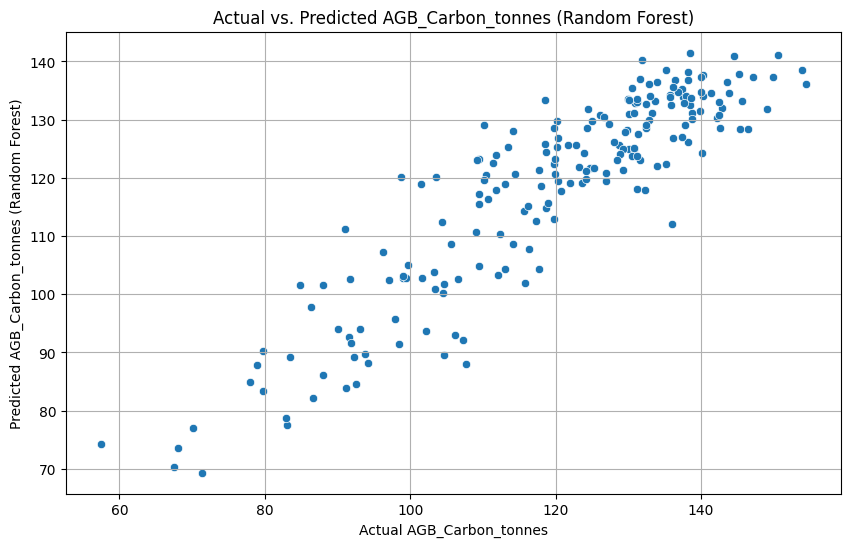

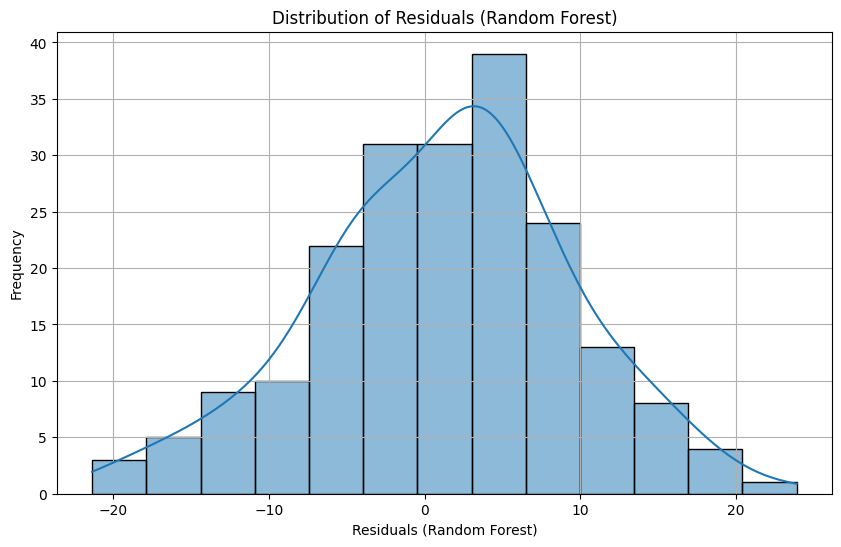

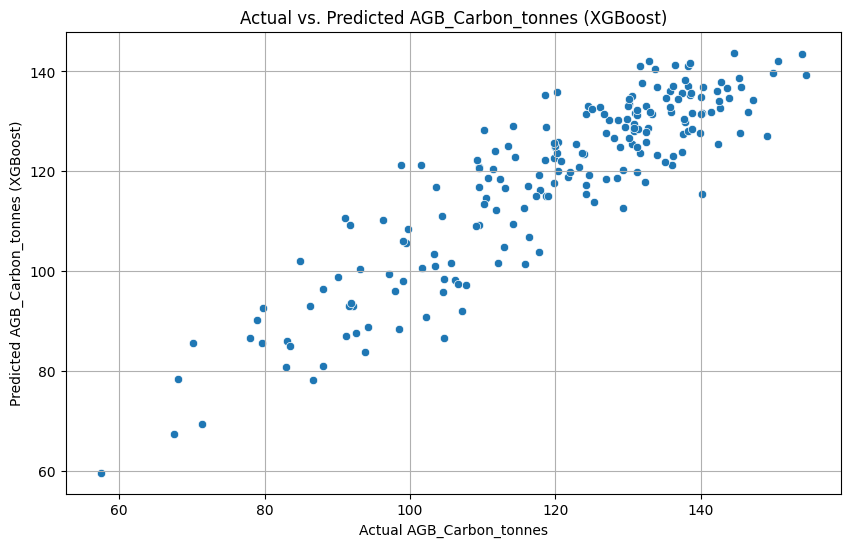

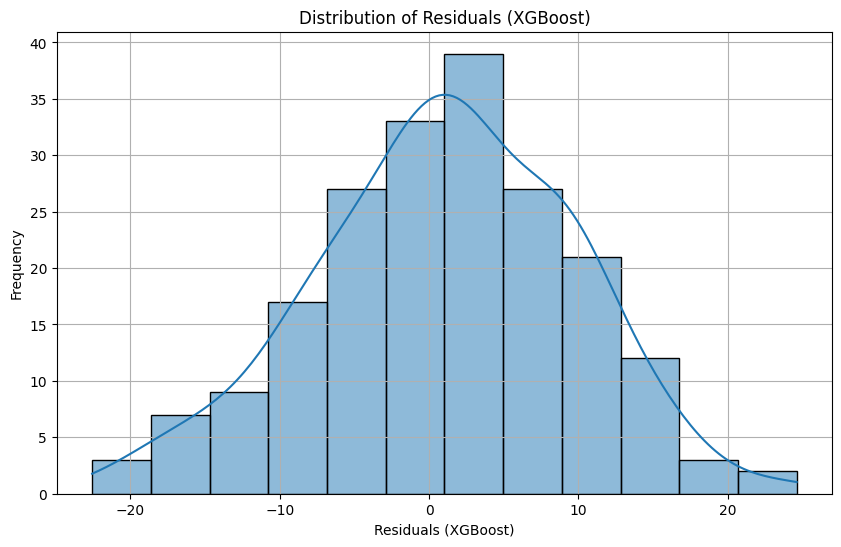

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot of actual vs predicted values for Random Forest
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=model.predict(X_test))
plt.xlabel("Actual AGB_Carbon_tonnes")
plt.ylabel("Predicted AGB_Carbon_tonnes (Random Forest)")
plt.title("Actual vs. Predicted AGB_Carbon_tonnes (Random Forest)")
plt.grid(True)
plt.show()

# Calculate residuals for Random Forest
residuals_rf = y_test - model.predict(X_test)

# Visualize the distribution of residuals for Random Forest
plt.figure(figsize=(10, 6))
sns.histplot(residuals_rf, kde=True)
plt.xlabel("Residuals (Random Forest)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Random Forest)")
plt.grid(True)
plt.show()

# Create a scatter plot of actual vs predicted values for XGBoost
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=xgb_model.predict(X_test))
plt.xlabel("Actual AGB_Carbon_tonnes")
plt.ylabel("Predicted AGB_Carbon_tonnes (XGBoost)")
plt.title("Actual vs. Predicted AGB_Carbon_tonnes (XGBoost)")
plt.grid(True)
plt.show()

# Calculate residuals for XGBoost
residuals_xgb = y_test - xgb_model.predict(X_test)

# Visualize the distribution of residuals for XGBoost
plt.figure(figsize=(10, 6))
sns.histplot(residuals_xgb, kde=True)
plt.xlabel("Residuals (XGBoost)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (XGBoost)")
plt.grid(True)
plt.show()

#Goal - Summary


### Data Analysis Key Findings

* The data was successfully split into training and testing sets, with 80% allocated for training and 20% for testing.
* A `RandomForestRegressor` and `XGBoost` model were selected and trained on the training data.
* The trained models achieved the following:  
                  * Random Forest MSE: 69.82  
                  * Random Forest R2: 0.82  
                  * XGBoost MSE: 75.40    
                  * XGBoost R2: 0.80  
                    
* A scatter plot of actual versus predicted values showed a positive linear correlation, indicating both models captures the general trend.
* The distribution of residuals is roughly centered around zero and approximately bell-shaped, suggesting random errors without strong systematic bias.

### Insights or Next Steps

* The RF model shows good performance with an R2 score of 0.82, indicating it explains a significant portion of the variance in AGB\_Carbon\_tonnes.
* Further analysis of features could be performed to identify the most influential factors in predicting AGB\_Carbon\_tonnes.